# 1D Offshore Spectrum to Nearshore observations

This version of the code used pytorch

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#handy function for emptying the chached memory in a GPU
#the kernal should be restarted every time this is run
from numba import cuda
cuda.select_device(0)
cuda.close()

### Read in 1d Spectrum

The one dimensional spectrum is stored per timestep in the dataframe, the frequencies don't change.

In [3]:
oneD_Off = pd.read_csv('../data/spec1D_offshore.csv', header = 0, index_col = 0, parse_dates = True)
oneD_Off = oneD_Off.apply(pd.to_numeric, errors='coerce')

<Axes: >

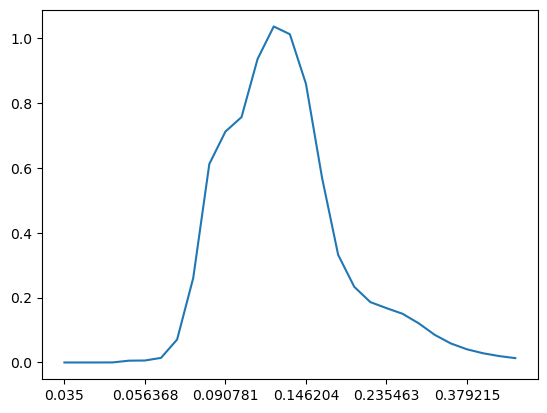

In [4]:
oneD_Off.iloc[300].plot()


We also need to ensure that we have some understanding of direction, so we will read in the offshore wave parameters.

In [5]:
offStats = pd.read_csv("../data/stats_offshore.csv", index_col = 0 , parse_dates =True )
offStats = offStats.apply(pd.to_numeric, errors='coerce')
offStats = offStats.drop(['lat', 'lon'], axis=1)

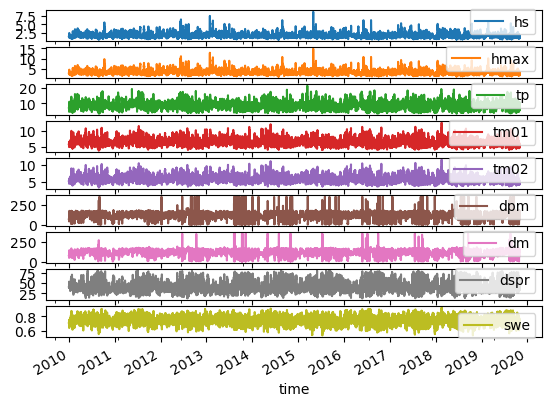

In [6]:
_ = offStats.plot(subplots = True)

## Read in Observational Data

Observational data is available from a number of sources we need to bring them together.

In [7]:
Obs = pd.read_csv('../data/obs_GC.csv', parse_dates = True, index_col = 0)
Obs.columns = ['hs','hmax','tp','tz','dp']

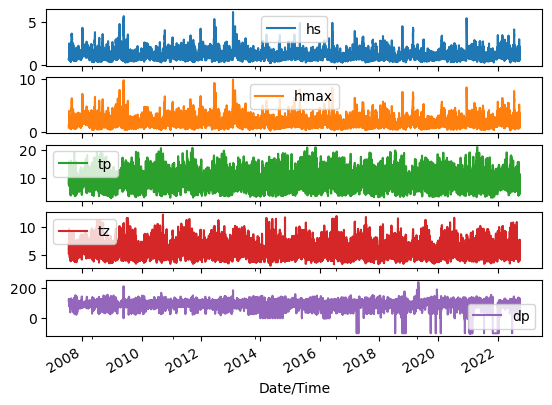

In [8]:
_ = Obs.plot(subplots = True)

In [9]:
new_columns = [column + '_tgt' for column in Obs.columns]
Obs = Obs.rename(columns=dict(zip(Obs.columns, new_columns)))

In [10]:
merged_df = pd.merge(oneD_Off, offStats, left_index=True, right_index=True)
merged_df = pd.merge(merged_df, Obs, left_index=True, right_index=True)

<Axes: >

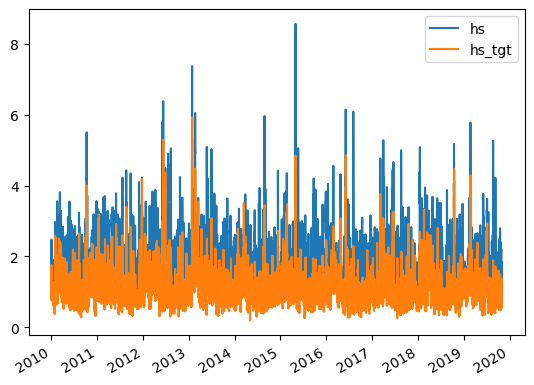

In [11]:
merged_df[['hs','hs_tgt']].plot()

## Feature Engineering

**Time Based**

In [12]:
def feature_engineering_time_series(data):
    # Extracting features from the DateTimeIndex
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Adding cyclic timing features
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # Additional feature engineering steps can be added here
    
    return data

In [13]:
merged_df = feature_engineering_time_series(merged_df)

**Direction Based**

In [14]:
def feature_engineering_wave_direction(data, direction_columns):
    for column in direction_columns:
        # Creating circular features for wave direction
        data[f'{column}_sin'] = np.sin(np.radians(data[column]))
        data[f'{column}_cos'] = np.cos(np.radians(data[column]))
        
        # Removing the original column
        data.drop(column, axis=1, inplace=True)
    
    
    return data

In [15]:
merged_df.columns

Index(['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735', 'hs', 'hmax',
       'tp', 'tm01', 'tm02', 'dpm', 'dm', 'dspr', 'swe', 'hs_tgt', 'hmax_tgt',
       'tp_tgt', 'tz_tgt', 'dp_tgt', 'year', 'month', 'day', 'day_of_week',
       'hour', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos'],
      dtype='object')

In [16]:
dp_col = list(merged_df.columns[merged_df.columns.str.contains('Dir_Tp TRUE_tgt')])
dpm_col = list(merged_df.columns[merged_df.columns.str.contains('dpm')])
dm_col = list(merged_df.columns[merged_df.columns.str.contains('dm')])

In [17]:
merged_df = feature_engineering_wave_direction(merged_df, dpm_col + dm_col + dp_col)

In [18]:
merged_df['hs+3'] = merged_df['hs'].shift(3)
merged_df['hs+6'] = merged_df['hs'].shift(6)
merged_df['hs+12'] = merged_df['hs'].shift(12)
merged_df['hs+24'] = merged_df['hs'].shift(24)

In [19]:
merged_df.dropna(inplace = True)

In [20]:
merged_df = merged_df.iloc[::2, :] #make 3 hourly

## Keep some independent data

In [21]:
ind_data = merged_df["2019-01-01":]
merged_df  = merged_df[:"2019-01-01"]

## Selecting Training Data

In [22]:
merged_df.columns

Index(['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735', 'hs', 'hmax',
       'tp', 'tm01', 'tm02', 'dspr', 'swe', 'hs_tgt', 'hmax_tgt', 'tp_tgt',
       'tz_tgt', 'dp_tgt', 'year', 'month', 'day', 'day_of_week', 'hour',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'dpm_sin', 'dpm_cos', 'dm_sin', 'dm_cos',
       'hs+3', 'hs+6', 'hs+12', 'hs+24'],
      dtype='object')

In [23]:
features_col = ['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735','tm02','dm_sin','hour_sin', 'hs','hmax']

In [24]:
labels_col = ['hs_tgt']

In [25]:
features = merged_df[features_col].values
labels = merged_df[labels_col].values

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [27]:
from sklearn.model_selection import TimeSeriesSplit

In [28]:
T = 18                    #Number of timesteps to look while predicting
D = features.shape[1]   #Dimensionality of the input
N = len(features) - T
print(f'Dimensions are {T} × {D} × {N}')

Dimensions are 18 × 34 × 26035


In [29]:
from sklearn.preprocessing import StandardScaler
#Train size: 80% of the total data size
train_size = int(len(features) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(features[:train_size + T - 1])
features = scaler.transform(features)

In [30]:
# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = features[t:t+T]
  y_train[t] = (labels[t+T])

In [31]:
# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = features[t:t+T]
  y_test[i] = (labels[t+T])

## Pytorch Data Preparation

In [32]:
import torch
import torch.nn as nn

In [33]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [34]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

## Construct simple LTSM

In [35]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    
    return out


For the number of hidden layers, the recommendation is 1 for simple problems and 2 for complex features. As our time series is slightly complex, I will be using 2.

Considering our training data size of 25,000> and input dimensionality; it's better to use hidden size at least 100 and at most 1000. 512 yielded good result.

In [36]:
model = LSTM(D, 256, 2, 1)
model.to(device)

LSTM(
  (rnn): LSTM(34, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [37]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=250):

  # Loss and optimizer
  criterion = nn.MSELoss()
  #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  loser = 1
  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()
    
    
    if (epoch + 1) % 50 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
      checkpoint(model, "best_model.pth")
      #evaluate
      if loser > test_loss.item():
        print(f'current test best = {loser:.3f}, current test loss is: {test_loss.item():.3f}')
        print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
        loser = test_loss.item()
        continue
      else:
        break
  return train_losses, test_losses

To do: 
- We need to add better early stopping approach that works on a per epoch and is wise enough to give 5 or more epochs before using the best one
- Need to test alternative learning rates, results seem to vary wildly depending on the learning rate.

## Train the Model

In [38]:

# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, test_losses = train(model,
                                    0.01,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=300)

At epoch 25 of 300, Train Loss: 0.067, Test Loss: 0.062
current test best = 1.000, current test loss is: 0.062
At epoch 25 of 300, Train Loss: 0.067, Test Loss: 0.062
At epoch 50 of 300, Train Loss: 0.033, Test Loss: 0.039
current test best = 0.062, current test loss is: 0.039
At epoch 50 of 300, Train Loss: 0.033, Test Loss: 0.039
At epoch 75 of 300, Train Loss: 0.027, Test Loss: 0.037
current test best = 0.039, current test loss is: 0.037
At epoch 75 of 300, Train Loss: 0.027, Test Loss: 0.037
At epoch 100 of 300, Train Loss: 0.023, Test Loss: 0.040


Find the best model from the training and load that in over the top of the latest one!

In [39]:
resume(model, "best_model.pth")

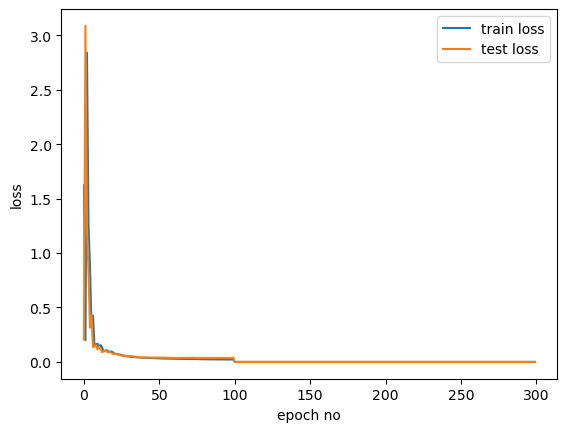

In [40]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()
     

## Assess performance against test data

In [41]:

#Checking one-step prediction performance of the model
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
  input_ = X_test[i].reshape(1, T, D)
  p = model(input_)[0,0].item()

  # update the predictions list
  test_predictions.append(p)
  

In [42]:

plot_len = len(test_predictions)
plot_df = merged_df[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions
plot_df.head(5)

,hs_tgt,prediction
2017-03-19 03:00:00,1.87,1.483498
2017-03-19 06:00:00,1.81,1.448683
2017-03-19 09:00:00,1.71,1.417910
2017-03-19 12:00:00,1.71,1.409269
2017-03-19 15:00:00,1.61,1.402563


Text(0, 0.5, 'Hs (m)')

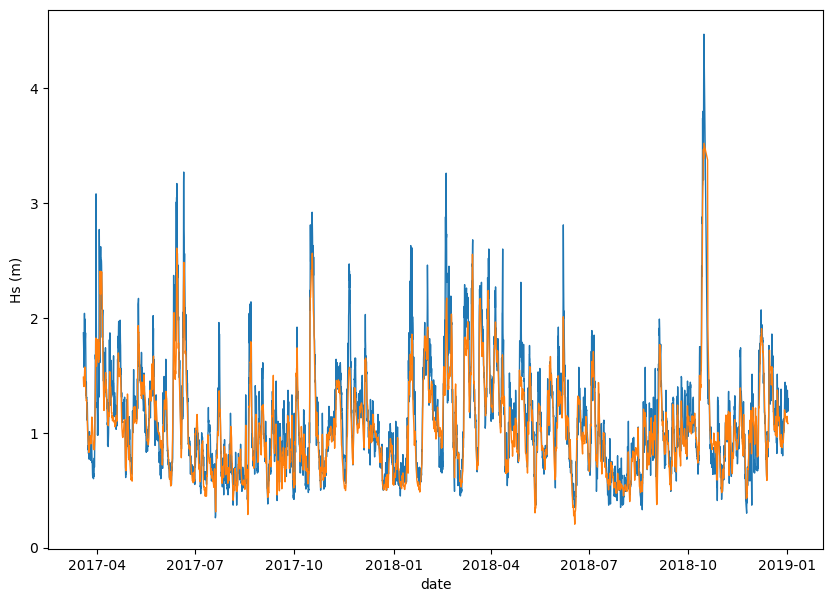

In [43]:
fig = plt.figure(figsize = (10, 7))
plt.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


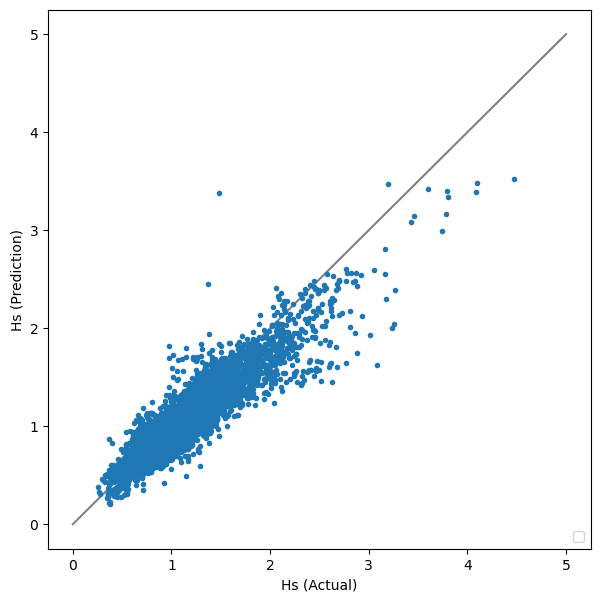

In [44]:
fig = plt.figure(figsize = (7, 7))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df[labels_col].values, plot_df['prediction'], '.')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

We are seeing a good fit. However, it seems the model is not good at predicting rapid increase/decrease in a short-period of time or picking out the extremes.

In [45]:
LTSM_error = pd.DataFrame(test_target, columns = ['targets'])
LTSM_error['predictions'] =test_predictions
LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
LTSM_error['error_square'] = LTSM_error['error'] ** 2
err = LTSM_error['error_square'].mean()
print(f'Mean square error is: {err:.3f}')

Mean square error is: 0.040


Text(0.5, 1.0, 'Distribution of Differences')

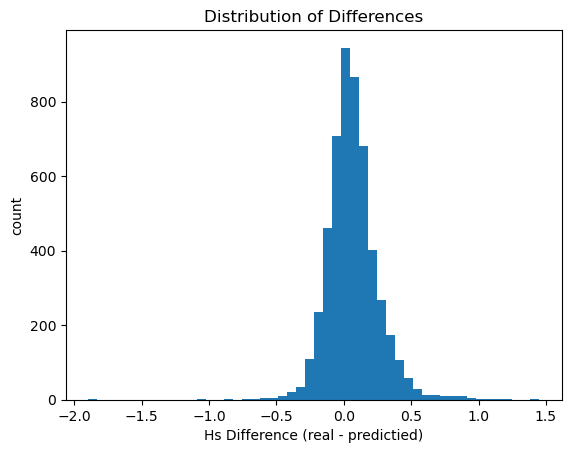

In [46]:
plt.hist(LTSM_error['error'], bins=50)
plt.xlabel('Hs Difference (real - predictied)')
plt.ylabel('count')
plt.title('Distribution of Differences')

## Test against independent data

In [47]:
features_ind = scaler.transform(ind_data[features_col].values)

In [48]:
len(ind_data)

2400

In [49]:
N = len(ind_data) - T
#need to remove this step.... and adjust code below
ind_size = int(len(ind_data) * 0.01)

# Preparing X_test and y_test
X_ind = np.zeros((N - ind_size, T, D))
y_ind = np.zeros((N - ind_size, 1))

for i in range(N - ind_size):
  t = i + ind_size
  X_ind[i, :, :] = features_ind[t:t+T]
  y_ind[i] = (ind_data[labels_col].values[t+T])




In [50]:
X_ind = torch.from_numpy(X_ind.astype(np.float32))
y_ind = torch.from_numpy(y_ind.astype(np.float32))

X_ind, y_ind = X_ind.to(device), y_ind.to(device)

In [51]:
X_ind[i].shape

torch.Size([18, 34])

In [52]:
ind_predictions = []
for i in range(len(y_ind)):
  input_ = X_ind[i].reshape(1, T, D)
  p = model(input_)[0,0].item()

  # update the predictions list
  ind_predictions.append(p)

In [53]:

plot_len = len(ind_predictions)
plot_df = ind_data[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = ind_predictions
plot_df['prediction'] = plot_df['prediction'].shift(1)
plot_df.dropna(inplace = True)
plot_df.head(5)

,hs_tgt,prediction
2019-01-06 09:00:00,1.42,1.275382
2019-01-06 12:00:00,1.43,1.292839
2019-01-06 15:00:00,1.43,1.288379
2019-01-06 18:00:00,1.38,1.279237
2019-01-06 21:00:00,1.35,1.271999


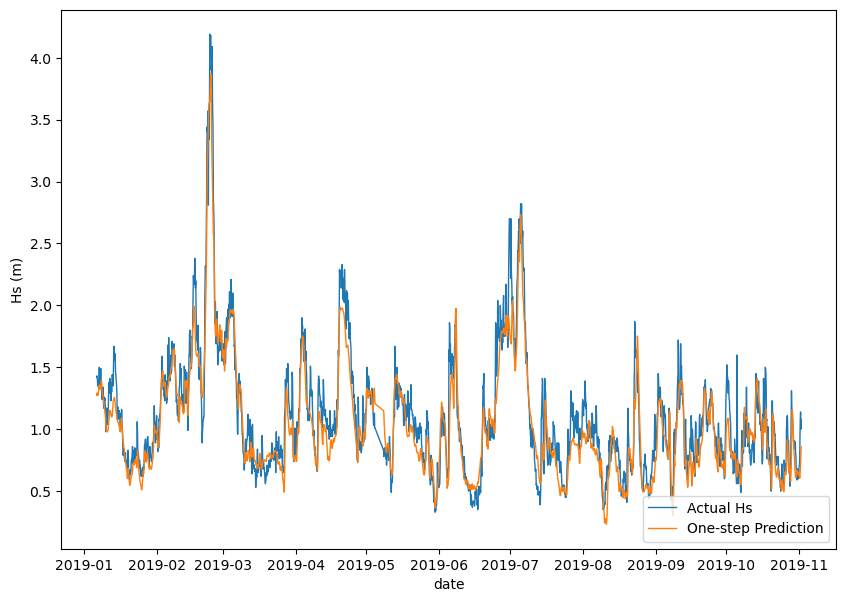

In [54]:
fig = plt.figure(figsize = (10, 7))
plt.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')
plt.legend(loc='lower right')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


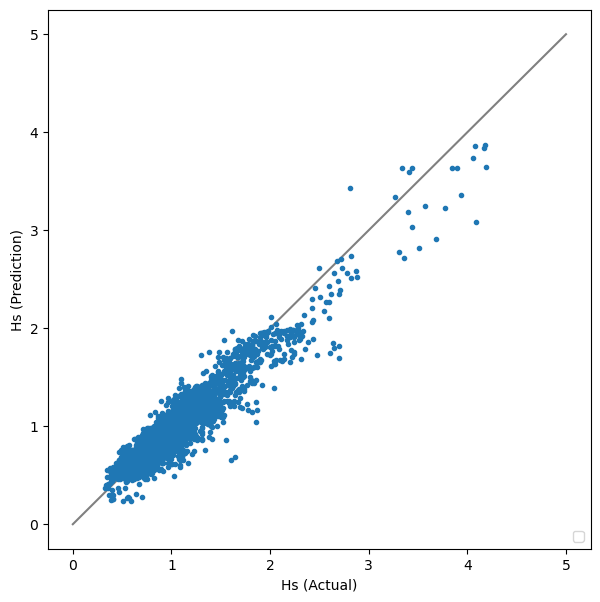

In [55]:
fig = plt.figure(figsize = (7, 7))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df[labels_col].values, plot_df['prediction'], '.')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

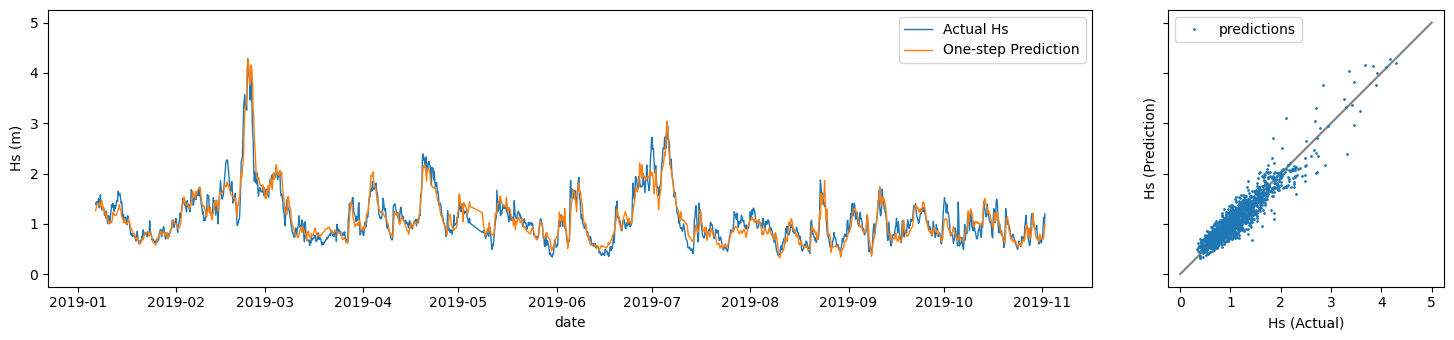

In [208]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3.5), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)  # Increase the width of the figure, adjust the width ratios, and share the y-axis

# Line timeseries plot
ax1.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
ax1.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
ax1.set_xlabel('date')
ax1.set_ylabel('Hs (m)')
ax1.legend(loc='upper right')

# Scatter plot
ax2.plot([0, 5], [0, 5], color='grey')
ax2.plot(plot_df[labels_col].values, plot_df['prediction'], '.', markersize=2, label='predictions')
ax2.set_xlabel('Hs (Actual)')
ax2.set_ylabel('Hs (Prediction)')
ax2.legend(loc='upper left')
ax2.set_aspect('equal')  # Set aspect ratio to 'equal'

plt.tight_layout()
plt.savefig('./plots/independent_data_prediction.png', dpi=300, bbox_inches='tight')


In [83]:
import cal_stats

In [206]:
cal_stats.all_stats(plot_df['prediction'].values, plot_df[labels_col].values.flatten())

{'Bias': -0.01,
 'Root Mean Squared Error': 0.18,
 'Scatter Index': 16.1,
 'Coefficient of Determination': 0.88,
 'Coefficient of Efficiency': 0.88,
 'Correlation Coefficient': 0.94,
 'Index of Agreement': 0.97}

In [159]:
# %%

# Define the number of timesteps to predict
num_timesteps = 5

# Prepare X_ind and y_ind for multiple timesteps prediction
X_ind = np.zeros((N - ind_size - num_timesteps + 1, num_timesteps, D))
y_ind = np.zeros((N - ind_size - num_timesteps + 1, num_timesteps))

for i in range(N - ind_size - num_timesteps + 1):
  t = i + ind_size
  X_ind[i, :, :] = features_ind[t:t+num_timesteps]
  y_ind[i] = ind_data[labels_col].values[t:t+num_timesteps].reshape(num_timesteps,)

# Convert X_ind and y_ind to tensors
X_ind = torch.from_numpy(X_ind.astype(np.float32))
y_ind = torch.from_numpy(y_ind.astype(np.float32)).flatten()  # Flatten y_ind


X_ind, y_ind = X_ind.to(device), y_ind.to(device)

# %%
X_ind[i].shape

# %%
ind_predictions = []
for i in range(len(y_ind)):
  input_ = X_ind[i].reshape(1, num_timesteps, D)
  p = model(input_)[0].tolist()

  # update the predictions list
  ind_predictions.extend(p)

# Reshape the predictions array
ind_predictions = np.array(ind_predictions).reshape(-1, num_timesteps)




IndexError: index 1568 is out of bounds for dimension 0 with size 1568

In [158]:
X_ind[i:]

tensor([[[-3.8342e-02, -3.7515e-02,  9.6753e-03,  ...,  9.9911e-01,
          -4.4199e-01, -4.4466e-01],
         [-3.8342e-02, -5.7495e-02, -3.2629e-02,  ...,  1.2237e+00,
          -4.2338e-01, -4.2451e-01],
         [-3.8342e-02, -7.0776e-02, -6.1808e-02,  ..., -3.9753e-04,
          -2.4806e-01, -2.3669e-01],
         [-3.8342e-02, -7.9778e-02, -8.5354e-02,  ..., -1.3658e+00,
          -3.2239e-01, -3.2599e-01],
         [-3.8342e-02, -7.9778e-02, -7.1649e-02,  ..., -9.9991e-01,
          -3.0948e-01, -3.2212e-01]],

        [[-3.8342e-02, -5.7495e-02, -3.2629e-02,  ...,  1.2237e+00,
          -4.2338e-01, -4.2451e-01],
         [-3.8342e-02, -7.0776e-02, -6.1808e-02,  ..., -3.9753e-04,
          -2.4806e-01, -2.3669e-01],
         [-3.8342e-02, -7.9778e-02, -8.5354e-02,  ..., -1.3658e+00,
          -3.2239e-01, -3.2599e-01],
         [-3.8342e-02, -7.9778e-02, -7.1649e-02,  ..., -9.9991e-01,
          -3.0948e-01, -3.2212e-01],
         [-3.8342e-02, -7.9778e-02, -5.3010e-02,  ...

In [151]:
ind_data[labels_col].values[t:t+num_timesteps].reshape(5,)

array([1.42, 1.43, 1.38, 1.34, 1.32])

In [144]:
input_ = X_ind[-12:].reshape(12, T, D)
model(input_)

tensor([[0.5665],
        [0.5707],
        [0.5876],
        [0.6256],
        [0.6543],
        [0.6653],
        [0.6201],
        [0.5984],
        [0.6591],
        [0.7869],
        [0.8633],
        [0.9153]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Compare to a simple xboost model

In [58]:
import xgboost as xgb

In [59]:
features.shape

(17369, 34)

In [60]:
labels.shape

(17369, 1)

In [61]:
# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

train_X, test_X = features[:train_size], features[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

# Fit the model
model.fit(train_X, train_y, eval_set=[(test_X, test_y)], verbose=False)

# Make predictions
predictions = model.predict(test_X)


In [62]:
plot_len = len(predictions)
plot_df = merged_df[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = predictions
plot_df.head(5)

,hs_tgt,prediction
2017-03-16 23:00:00,1.71,1.036096
2017-03-17 03:00:00,1.38,1.189543
2017-03-17 08:00:00,1.46,1.121853
2017-03-17 12:00:00,1.38,1.009145
2017-03-17 17:00:00,1.39,1.142602


Text(0, 0.5, 'Hs (m)')

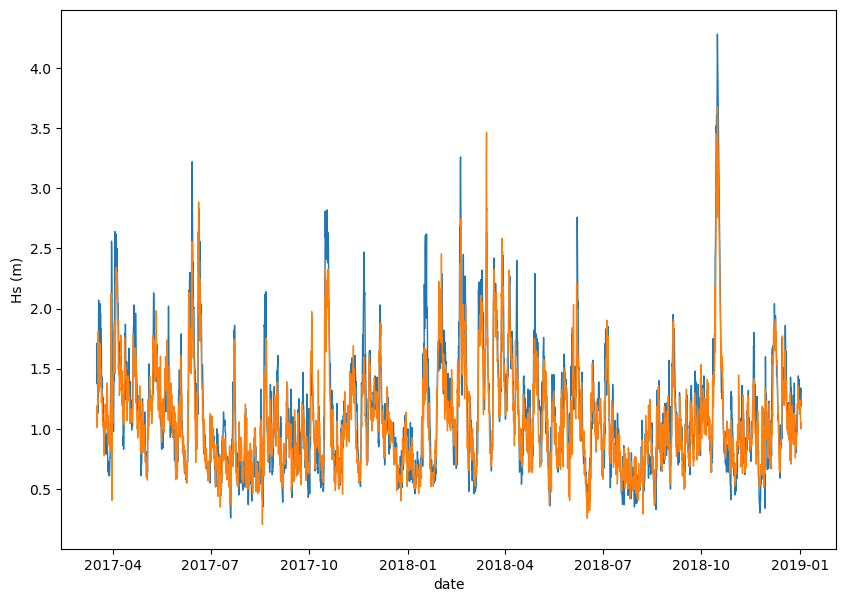

In [63]:
fig = plt.figure(figsize = (10, 7))
plt.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
plt.plot(pd.DataFrame(predictions, index = plot_df.index), label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


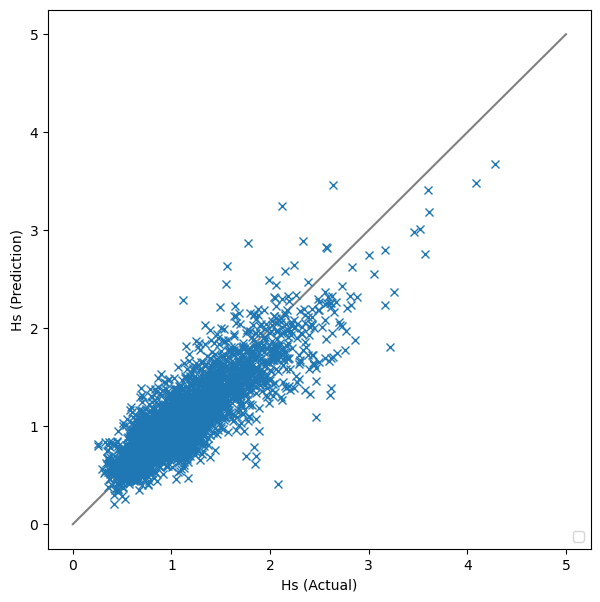

In [64]:
fig = plt.figure(figsize = (7, 7))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df[labels_col].values, plot_df['prediction'], 'x')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

In [65]:
from xgboost import plot_importance
from matplotlib import pyplot

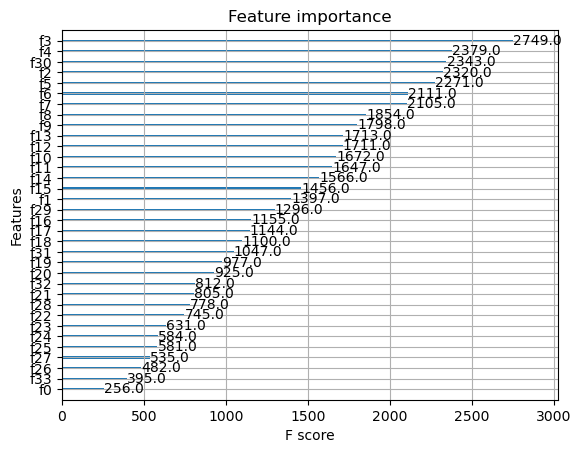

In [66]:
plot_importance(model)
pyplot.show()

In [67]:
cal_stats.all_stats(plot_df['prediction'].values, plot_df[labels_col].values.flatten())

{'Bias': -0.05,
 'Root Mean Squared Error': 0.25,
 'Scatter Index': 22.1,
 'Coefficient of Determination': 0.74,
 'Coefficient of Efficiency': 0.73,
 'Correlation Coefficient': 0.86,
 'Index of Agreement': 0.92}